<a href="https://colab.research.google.com/github/aulphin/Focus_Shifting_atk_exp/blob/main/RISE_FS_atk_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/FS_Attack-main

/content/drive/MyDrive/FS_Attack-main


Importing Libraries

In [ ]:
from collections import defaultdict
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch
from skimage.transform import resize

Input Img Process

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the image
image_path = 'tmp_image/0.jpeg'
image = Image.open(image_path).convert('RGB')

# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(image).unsqueeze(0).to(device)

Generate Random mask

In [ ]:
# Generate RISE masks
def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s).astype(int)
    up_size = (s + 1) * cell_size
    masks = np.empty((N, *input_size))

    for i in range(N):
        grid = (np.random.rand(s, s) < p1).astype('float32')
        resized = resize(grid, up_size, order=1, mode='reflect', anti_aliasing=False)
        x, y = np.random.randint(0, cell_size[0]), np.random.randint(0, cell_size[1])
        masks[i] = resized[x:x + input_size[0], y:y + input_size[1]]

    return masks[..., np.newaxis]  # Add channel dimension

Image- Mask Multiplication

In [ ]:
def explain_RISE_AD(model, inp, masks, N, batch_size, p1):
    model.eval()

    # Convert input and masks to tensors on the correct device
    inp = torch.tensor(inp.copy(), dtype=torch.float32).to(device)
    masks = torch.tensor(masks.copy(), dtype=torch.float32).squeeze(-1).unsqueeze(1).to(device)

    # Repeat masks to match input channels (N, 3, H, W)
    masks = masks.repeat(1, 3, 1, 1)

    # Apply masks
    masked = inp * masks

    # Forward pass in batches
    preds = []
    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch = masked[i:i + batch_size]
            preds.append(model(batch).cpu().numpy())
    preds = np.concatenate(preds)

    # Compute saliency map
    sal = preds.T @ masks.cpu().numpy().reshape(N, -1)
    sal = sal.reshape(-1, *model.input_size) / (N * p1)

    # Average over channels
    sal = sal.mean(axis=0) if sal.ndim > 2 else sal

    return sal


Pre-trained Resnet-50 Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.resnet50(weights='DEFAULT')
        self.model.eval()
        self.input_size = (224, 224)

    def forward(self, x):
        return self.model(x)

    def classify(self, x):
        with torch.no_grad():
            preds = self.forward(x)
            class_idx = torch.argmax(preds, dim=1)
        return preds, class_idx

In [ ]:
model = Model().to(device)

In [ ]:
# === Generate Original RISE Explanation ===
org_masks = generate_masks(2000, 8, 0.5, model.input_size)
org_expl = explain_RISE_AD(model, img_tensor.cpu().numpy(), org_masks, 2000, 32, 0.5)
org_expl_torch = torch.tensor(org_expl, dtype=torch.float32).to(device)


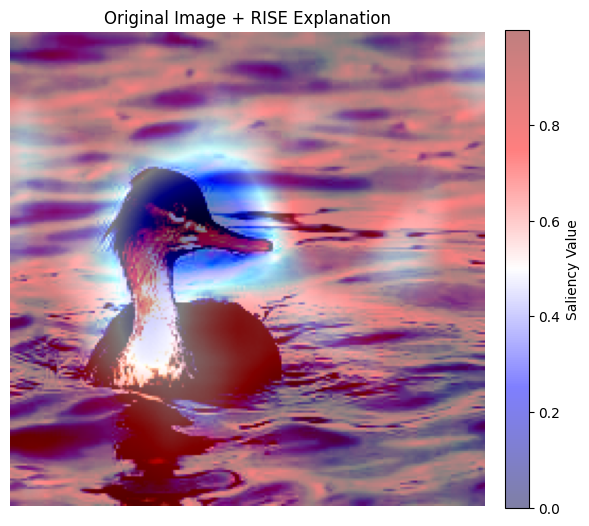

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert adversarial image to NumPy
org_image_np = img_tensor.detach().cpu().numpy().squeeze()
org_image_np = np.transpose(org_image_np, (1, 2, 0))
org_image_np = np.clip(org_image_np * 255, 0, 255).astype(np.uint8)

# Normalize saliency map for better contrast
org_expl_np = org_expl_torch.detach().cpu().numpy()
org_expl_np = (org_expl_np - org_expl_np.min()) / (org_expl_np.max() - org_expl_np.min() + 1e-8)

# Plot with overlay
plt.figure(figsize=(6, 6))
plt.imshow(org_image_np)
plt.imshow(org_expl_np, cmap='seismic', alpha=0.5)
plt.colorbar(label="Saliency Value", fraction=0.046, pad=0.04)
plt.title("Original Image + RISE Explanation")
plt.axis("off")
plt.tight_layout()
plt.show()


Center_Atk_Matrix_Function

In [ ]:
def get_center_attack_matrix(x, y, r, org_expl, L):
    """
    Generates a center attack matrix based on the explanation map.

    Parameters:
        x (int): x-coordinate of the center.
        y (int): y-coordinate of the center.
        r (int): Radius for the attack.
        org_expl (torch.Tensor): Explanation map.
        L (int): Size of the matrix.

    Returns:
        np.ndarray: Attack matrix.
    """
    exp_list = org_expl.flatten().cpu().numpy()  # Convert to numpy for processing
    exp_list_sort_idx = np.argsort(exp_list)[::-1]  # Indices of sorted explanations
    exp_list_sort = exp_list[exp_list_sort_idx]  # Sorted explanations
    mtx = np.zeros((L, L))

    # Initialize dictionaries
    counter_dict = defaultdict(int)
    counter_dict_sum = defaultdict(int)

    # Compute distance-based counts
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x + 1) + np.abs(j - y + 1)
            counter_dict[n1] += 1

    # Compute cumulative counts
    max_n1 = max(x - 1 + y - 1, y + L - x - 1, L - x + L - y, L - y - 1 + x)
    for i in range(max_n1):
        if i == 0:
            counter_dict_sum[i] = 1
        else:
            counter_dict_sum[i] = counter_dict[i] + counter_dict_sum[i - 1]

    # Fill the matrix
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x + 1) + np.abs(j - y + 1)
            idx = counter_dict_sum.get(n1 - 1, 0)
            if idx >= len(exp_list_sort):
                idx = len(exp_list_sort) - 1  # Cap index to the maximum available index

            if n1 == 0:
                mtx[i, j] = exp_list_sort[0]
            elif n1 == 1:
                mtx[i, j] = exp_list_sort[1]
            elif n1 < r:
                mtx[i, j] = exp_list_sort[idx]
            else:
                mtx[i, j] = -exp_list_sort[min(len(exp_list_sort) - 1, counter_dict_sum.get(max_n1 + 1, 0))]

    return mtx

In [ ]:
import torch
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

prefactors = [0.01, 0.001]  # [weight_expl_loss, weight_output_loss]
learning_rate = 1e-4
EARLY_STOP = True
early_stop_epoch = 0

# Initialize adversarial example and optimizer
x_adv = img_tensor.clone().detach().to(device).requires_grad_(True)
optimizer = torch.optim.Adam([x_adv], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)


In [ ]:
# === Initialize Loss Function & Storage ===
mse_loss = nn.MSELoss()
total_loss_list, epoch_exp = [], []
L1_score, L2_score, L3_score, L4_score, L5_score = [], [], [], [], []

# === Original & Adversarial Predictions ===
origin_prediction_class = model(img_tensor).argmax().item()
adv_prediction_class = model(x_adv).argmax().item()
org_acc = model(x_adv).clone().detach()


# Debug: Check the shape of the explanation tensor
# print("org_expl_torch shape:", org_expl_torch.shape)  # Should now be [224, 224]

# === Center-Based Target Explanation Map ===
L = org_expl_torch.shape[0]
x_center, y_center = L // 2, L // 2
r_attack = 10

target_mtx = get_center_attack_matrix(x_center, y_center, r_attack, org_expl_torch, L)
target_mtx_torch = torch.tensor(target_mtx, dtype=torch.float32, requires_grad=True).to(device)

# Ensure target shape matches explanation
if target_mtx_torch.shape != org_expl_torch.shape:
    target_mtx_torch = target_mtx_torch.view_as(org_expl_torch)


In [ ]:
adv_masks = generate_masks(2000, 8, 0.5, model.input_size)
num_iter = 100

In [ ]:
# Define attack and explanation loop
for i in range(num_iter):
    optimizer.zero_grad()  # Reset gradients

    # Forward pass for the adversarial image
    adv_output = model(x_adv)

    # Compute adversarial accuracy for the output
    adv_acc = adv_output.clone().detach()

    # Compute explanation for the adversarial image using RISE
    #adv_masks = generate_masks(2000, 8, 0.5, model.input_size)
    adv_expl = explain_RISE_AD(model, x_adv.detach().cpu().numpy(), adv_masks, 2000, 32, 0.5)
    adv_expl_torch = torch.tensor(adv_expl).to(device).float()

    # Ensure target matrix has matching shape
    if target_mtx_torch.shape != adv_expl_torch.shape:
        target_mtx_torch = target_mtx_torch.view_as(adv_expl_torch)

    # Loss 1: MSE between the explanation maps (i.e., attacking the explanation)
    L1 = mse_loss(adv_expl_torch, target_mtx_torch)

    # Loss 2: Difference between original and adversarial outputs (to minimize classification accuracy)
    L2 = mse_loss(adv_acc[0][adv_prediction_class], org_acc[0][origin_prediction_class].detach())

    # Weighted sum of losses
    total_loss = prefactors[0] * L1 + prefactors[1] * L2
    total_loss_list.append(total_loss.item())

    # Backpropagation
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Obtain new predictions
    predictions = model(x_adv)
    predictions = predictions.cpu().detach().numpy()

    # Update scores for top-5 classes
    index_sort = np.argsort(predictions[0])[::-1]
    L1_score.append(predictions[0][index_sort[0]])
    L2_score.append(predictions[0][index_sort[1]])
    L3_score.append(predictions[0][index_sort[2]])
    L4_score.append(predictions[0][index_sort[3]])
    L5_score.append(predictions[0][index_sort[4]])

    # Early stopping condition
    prediction_class_tmp = np.argmax(predictions[0])
    if i > 30 and origin_prediction_class != prediction_class_tmp:
        print(i, 'early done')
        early_stop_epoch = i
        if EARLY_STOP:
            x_adv = x_adv.clone().detach()
            break

    # Clamp the adversarial example
    x_adv.data = torch.clamp(x_adv.data, 0, 1)  # Ensure valid range [0, 1]

    # Update the adversarial saliency
    epoch_exp.append(adv_expl)

    # Debugging information
    if (i + 1) % 10 == 0 or i == 0:
        print(f"Iteration {i + 1}: Total Loss: {total_loss.item()}, Center Loss: {L1.item()}, Output Loss: {L2.item()}")



Iteration 1: Total Loss: 7.959879977370576e-11, Center Loss: 7.959879866348274e-09, Output Loss: 0.0
Iteration 10: Total Loss: 2.0519721147138625e-05, Center Loss: 1.1638441321792925e-08, Output Loss: 0.020519603043794632
Iteration 20: Total Loss: 2.0519721147138625e-05, Center Loss: 1.1638441321792925e-08, Output Loss: 0.020519603043794632
Iteration 30: Total Loss: 2.0519721147138625e-05, Center Loss: 1.1638441321792925e-08, Output Loss: 0.020519603043794632
Iteration 40: Total Loss: 2.0519721147138625e-05, Center Loss: 1.1638441321792925e-08, Output Loss: 0.020519603043794632
Iteration 50: Total Loss: 2.0519721147138625e-05, Center Loss: 1.1638441321792925e-08, Output Loss: 0.020519603043794632
Iteration 60: Total Loss: 2.0519721147138625e-05, Center Loss: 1.1638441321792925e-08, Output Loss: 0.020519603043794632
Iteration 70: Total Loss: 2.0519721147138625e-05, Center Loss: 1.1638441321792925e-08, Output Loss: 0.020519603043794632
Iteration 80: Total Loss: 2.0519721147138625e-05, Ce

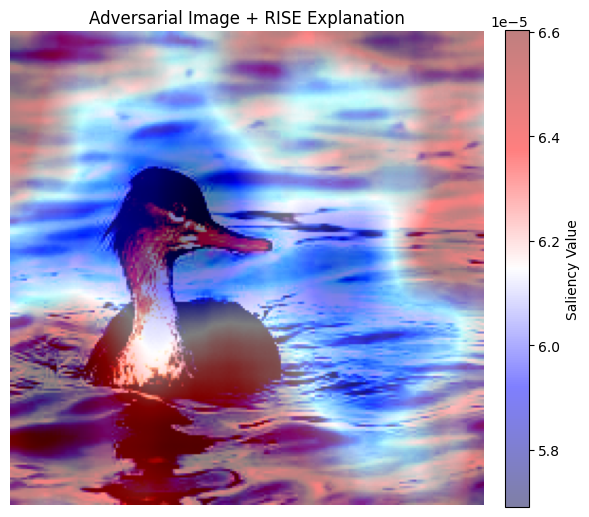

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert adversarial image to NumPy
adv_image_np = x_adv.detach().cpu().numpy().squeeze()
adv_image_np = np.transpose(adv_image_np, (1, 2, 0))
#adv_image_np = np.clip(adv_image_np * 255, 0, 255).astype(np.uint8)

# Normalize saliency map for better contrast
adv_expl_np = adv_expl_torch.detach().cpu().numpy()
#adv_expl_np = (adv_expl_np - adv_expl_np.min()) / (adv_expl_np.max() - adv_expl_np.min() + 1e-8)

# Plot with overlay
plt.figure(figsize=(6, 6))
plt.imshow(adv_image_np)
plt.imshow(adv_expl_np, cmap='seismic', alpha=0.5)
plt.colorbar(label="Saliency Value", fraction=0.046, pad=0.04)
plt.title("Adversarial Image + RISE Explanation")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  98  score:  6.6355195
label:  335  score:  2.641112
label:  131  score:  1.0086985
label:  299  score:  0.9492444
label:  58  score:  0.8123631


GINI Value

In [ ]:
def gini(array):
    array = np.array(array, dtype=np.float64)
    array = np.abs(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0] + 1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


In [ ]:
# computing GINI
from skimage import color

GINI_list = []
ori_gini_list = []
adv_gini_list = []
#adv_expl_np = adv_expl[0].cpu().detach().numpy()
#org_expl_np = org_expl[0].cpu().detach().numpy()

img1 = org_expl
img2 = adv_expl

GINI_diff = np.abs(gini(img1.flatten()) - gini(img2.flatten()))
GINI_list.append(GINI_diff)
ori_gini_list.append(gini(img1.flatten()))
adv_gini_list.append(gini(img2.flatten()))

In [ ]:
print(GINI_list)
print(ori_gini_list)
print(adv_gini_list)

[np.float64(0.0025118065630670774)]
[np.float64(0.020431311131058644)]
[np.float64(0.017919504567991566)]


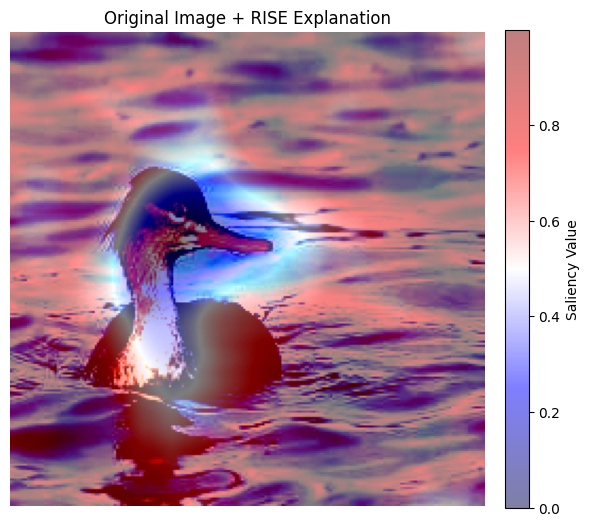

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert adversarial image to NumPy
org_image_np = img_tensor.detach().cpu().numpy().squeeze()
org_image_np = np.transpose(org_image_np, (1, 2, 0))
org_image_np = np.clip(adv_image_np * 255, 0, 255).astype(np.uint8)

# Normalize saliency map for better contrast
org_expl_np = org_expl_torch.detach().cpu().numpy()
org_expl_np = (org_expl_np - org_expl_np.min()) / (org_expl_np.max() - org_expl_np.min() + 1e-8)

# Plot with overlay
plt.figure(figsize=(6, 6))
plt.imshow(org_image_np)
plt.imshow(org_expl_np, cmap='seismic', alpha=0.5)
plt.colorbar(label="Saliency Value", fraction=0.046, pad=0.04)
plt.title("Original Image + RISE Explanation")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
 # Obtain new predictions
predict = model(img_tensor)
predict = predict.cpu().detach().numpy()


In [ ]:
value_sort = np.sort(predict[0])[::-1]
index_sort = np.argsort(predict[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  339  score:  8.301415
label:  603  score:  3.4204063
label:  676  score:  2.047838
label:  439  score:  2.0468848
label:  912  score:  1.8805132
